# **AFL Agent Tutorial: Notebook 01** <a href="https://colab.research.google.com/github/martintb/AFL-tutorial/blob/main/notebooks/01-introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Soft Material Phase Mapping

*Author: Tyler Martin - tyler.martin@nist.gov*


## Learning Goals

This notebook will introduce

- Soft Material Structrual Phase Diagrams
- Small Angle Neutron Scattering (SANS)
- Utilize Virtual Instruments for Data Simulation
- Data Handling with the Python package xArray


# Setup

**This may take several minutes to complete, please run ASAP**

Please run this collapsed cell by clicking in the box to the left of *8 cells hidden*. This will `pip install` and `import` all necessary dependencies for this tutorial. There is not need to expand this cell block, but you can if you're interested in looking under the hood.


If you've never used Google Colab before, [this FAQ](https://research.google.com/colaboratory/faq.html) may be useful to skim. It's very similar (and based off of) Jupyter, but divergent in several ways.

**Warning!**

If you disconnect for too long, you'll have to rerun this cell. Any text you type into this notebooks should always be saved, but variables in memory and files can dissappear when you disconnect.

You're free to download this notebook and run it locally if you're inclined, but we will provide no support for this.

In [ ]:
!git clone https://github.com/martintb/AFL-tutorial

In [ ]:
# primarily use predownloaded wheels
# add --no-index to ignore PyPI
!pip install --find-links ./AFL-tutorial/wheels ./AFL-tutorial/

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
import os

import sklearn.cluster
from sklearn.metrics import pairwise
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern

import plotly.express as px
import plotly.graph_objects as go

import xarray as xr
xr.set_options(display_expand_data=False)

In [ ]:
from AFL.double_agent_tutorial import *
from AFL.double_agent_tutorial.instruments.tutorial import *

In [5]:
np.random.seed(240424)

# Structural Phase Diagrams

A structural phase diagram maps out regions where materials adopt different structural arrangements at the molecular or nanoscale level. Unlike thermodynamic phase diagrams that show equilibrium states of matter (solid, liquid, gas), structural phase diagrams can reveal more subtle organizational changes within a single thermodynamic phase - for example, how molecules self-assemble into different geometries like spheres, cylinders or layered structures.

 The phase boundaries shown in the diagram below come from [Alexandridis et al, Langmuir 1998, 14, 2627-2638](https://pubs.acs.org/doi/pdf/10.1021/la971117c), who used X-ray diffraction to map out these structural transitions for a block copolymer surfactant. Each labeled region in the Figure corresponds to a different structural phase, as shown by the outer cartoons. While their work used X-ray techniques, our *virtual instrument* will generate analogous data using small-angle neutron scattering (SANS).

 The diagram below is a *ternary* phase diagram, which is used to show the relationships between three components in a system. Each point in a ternary diagram represents a unique composition that adds up to 100%. The corners represent pure components (100% of one component), the edges represent mixtures of two components, and points inside the triangle represent mixtures of all three components. The relative amounts can be read by following lines parallel to the triangle's edges. Ternary phase diagrams are particularly useful for mapping out how molecular structure and organization changes across different mixture compositions.


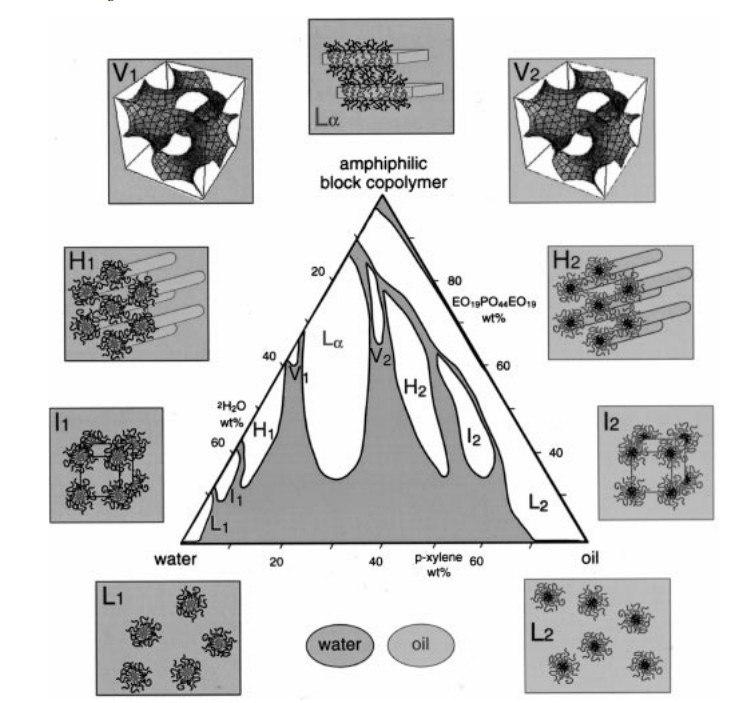

# Small Angle Scattering

insert image

Small angle scattering (SAS) is a powerful experimental technique used to study the structure and organization of materials at length scales from roughly 1-100 nanometers. In a SAS experiment, radiation (X-rays or neutrons) is directed at a sample and the scattered intensity is measured at small angles relative to the incident beam. The scattering pattern provides information about the size, shape, and arrangement of components within the material.

In this tutorial, we'll focus on small angle neutron scattering (SANS), which uses neutrons as the probe. SANS is particularly valuable for studying soft matter systems like polymers, surfactants, and biological materials. This is because neutrons interact with atomic nuclei rather than electrons (as X-rays do), which means:
1. Different isotopes of the same element can have very different scattering properties
2. Light elements like hydrogen can be easily detected
3. By selectively replacing hydrogen with deuterium in parts of a molecule ("selective deuteration"), we can create strong contrast between chemically similar components

These properties make SANS an ideal tool for studying the self-assembly and phase behavior of soft materials like the surfactant mixtures we'll examine in this tutorial.


# Virtual Instrument

insert image

This tutorial will work with *virtual instruments* that generate realistic SANS data that varies with sample composition. Our approach incorporates two key experimental effects that impact real SANS measurements. First, we include measurement noise in the scattered intensity (y-axis), which comes from counting statistics and instrumental factors. Second, we account for instrumental resolution effects (x-axis smearing), which arise from the wavelength spread of the neutron beam and geometric factors of the instrument. Both the noise and resolution effects in our virtual instrument are based on reference measurements from actual SANS experiments, ensuring the simulated data closely matches what would be obtained on a real instrument. Each challenge will feature an instrument with its own unique 'phase map' and specific parameters for generating the scattering data.

To start, let's initialize a virtual instrument.

In [ ]:
instrument = get_virtual_instrument()
instrument

We can view the 'ground truth' of this virtual instrument as so. The two colors in the ternary plot represent two phases. Hover over the diagram to view the composition at every point.

In [ ]:
instrument._plot_ground_truth_data();

Now, let's conduct a measurement at a mass fraction of

`(a, b, c) = (0.5, 0.0, 0.5)`

where a, b, and c, correspond to the mass fractions of pluronic, water, and oil. Note that, in this scheme a + b + c must sum to 1.0.

In [ ]:
dataset = instrument.measure(a=0.5,b=0.,c=0.5)
dataset

This returns an [xarray.Dataset](https://docs.xarray.dev/en/stable/) containing our virtual scattering data. We'll briefly discuss this data structure below but, first, let's plot the virtual scattering data from this 'measurement'.



In [ ]:
dataset.sas.plot.line(
    x='q',
    xscale='log',
    yscale='log',
    marker='.',
    ls='none',
)

Note how the above data has noise, stitching artifacts, and resolution effects. All of these will be important to consider in designing an active-learning agent.

We can also plot the composition the data was measured at in ternary coordinates using the helper function `plot_ternary`

**Important Note:** Plotly has issues displaying points on the ternary boundary. If you double click the ternary, it should show the point in the middle of the left side.

In [ ]:
plot_ternary(dataset,['c','a','b'],include_surface=False);

# A quick aside on xarray

Let's take a quick detour in to the primary data structure used in this tutorial. See [here](https://tutorial.xarray.dev/intro.html) for a more detailed tutorial. If you've used [`pandas`](https://pandas.pydata.org/) before, this all should feel familiar.

The two primary datastructures in `xarray` are `DataArrays` and `Datasets`. `DataArrays` can be thought of as `Numpy` arrays that have named axes called "dimensions" and (optionally) defined coordinates on those axes.  *In xarray, the dimension 'x' and the positions along that dimension (x=0.5, 1.0, 1.5, etc) are separate concepts.*

To demonstrate this, let's look at the `Dataset` that was returned from the virtual instrument above


In [ ]:
dataset

From the top row of the output, we see that the Dataset has 250 values in the `q`.

Under the **Coordinates** header, we can view the coordinates defined for these dimensions. Think of coordinates as x-axis values in an x-y scatter plot.

Under the **Data variables** header, we can see that we have 4 data variables. Click the 'page' icon at the right side of each row to read a description of the variable. Note that each variable has *dimensions* listed in parenthesis. Think of data variables as the y-values in a x-y scattering plot.

We can view specific DataArrays within the Dataset using dictionary indexing like so

In [ ]:
dataset['sas']

Note that you can always get back the underlying Numpy arrays using the `values` attribute

In [ ]:
dataset['sas'].values

`Datasets` and `DataArrays` have many ways to index and slice data, here's a brief demonstration of a few of them. Note that all of these selections can be applied to the entire dataset or a specific `DataArray` within the dataset.

We can access the tenth value of the sas xarray using classic, integer-based array access notation

In [ ]:
dataset['sas'][10]


xarray allows us to be more explicit and specify the dimension we're searching over. In this case, we use the `.isel()` method (index select method)

In [ ]:
dataset['sas'].isel(q=10)

More powerfully, we can search for specific coordinate values (rather than integer indices) using `.sel()`.

In [ ]:
dataset['sas'].sel(q=0.003915, method='nearest')

We can also slice across a range of values using explicit coordinate values

In [ ]:
dataset['sas'].sel(q=slice(0.003,0.01))

Finally, we can interpolate our data to specific q coordinate

In [ ]:
dataset['sas'].interp(q=0.04)

There is a lot more going on with xarray, but hopefully this will allow us to get started.

# Summary

In this notebook, we explored fundamental concepts for analyzing small angle neutron scattering (SANS) data in the context of structural phase diagrams. Key topics covered include:

 - Small angle scattering basics and how it probes structural information at the nanoscale
 - Working with virtual instruments and simulated SANS data
 - Using xarray, a powerful library for labeled multi-dimensional arrays, to analyze SANS data:
   - Loading and inspecting SANS datasets
   - Accessing specific data arrays and their coordinates
   - Selecting data using integer indices with `.isel()`
   - Selecting data using coordinate values with `.sel()`
   - Slicing data across coordinate ranges
   - Interpolating data to specific coordinate values

 These tools and concepts provide a foundation for investigating structural phase transitions and analyzing scattering patterns in complex materials.

